In [66]:
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Project Settings
## basic setting
asset price process follows BS model with $\mu=0.1, \sigma=0.25$
current spot price is 10 dollars
strike price is 10 dollars (option at the money)
transaction cost: 0.005 dollar per share, 0.005 dollar per option
only trade Integer number of shares and options
risk-free rate 5% per year

## Our position:
just sold 10_000 units of call at the money with 63 days to maturity (call this option g)
allow holding stock, bank account and another call option strike=10, maturity = 0.3 year (75.6 days) (call this option h)
Hedge frequency: 4 times per day

## Question 1
simulate 5000 paths, compare delta hedge and delta-gamma hedge pnl, how do they vary as $\mu$ varies ?

## Question 2
choose two sample path: one ends up in-the-money, one ends up out-of-money:
plot the hedging position of delta hedge and delta-gamma hedge, compare the two methods (transaction cost included)

## Question 3
suppose real-world P volatility is $\sigma \in ${20%,22%,...,30%} but you still sold the option and hedge using $\sigma=0.2$, compare again delta hedge and delta-gamma hedge


# Question 1

In [68]:
class BS():
    
    def CallPrice(self, S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        
        return S*stats.norm.cdf(dp) - K*np.exp(-r*T)*stats.norm.cdf(dm)
    
    
    
    def CallDelta(self, S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return stats.norm.cdf(dp)
    

    
    def CallGamma(self, S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return stats.norm.pdf(dp)/(S*sigma*np.sqrt(T))
    

In [70]:
class ATM_Call_Option_Dynamic_Hedging_Following_prof():
    def __init__(self,spot_price:float,mu:float,sigma:float,sigma_real:float,num_of_call_option_sold:int,Ntrials:int,option_maturity:float,type_of_hedge:str,hedging_option_maturity:Optional[float]=None,risk_free=0.05,stock_transaction_cost:float=0.005,option_transaction_cost:float=0.005,random_state:int=0):
        """
        
        :param spot_price: float, spot price of the underlying asset at t=0
        :param mu: BS model mu
        :param sigma: BS model sigma
        :param sigma_real: sigma under real-world P measure
        :param num_of_call_option_sold: int
        :param Ntrials: int
        :param option_maturity: float, maturity of the option we sold, fraction of year 
        :param hedging_frequency: how frequent we hedge, fraction of day
        :param type_of_hedge: ['delta','delta-gamma']
        :param hedging_option_maturity: optional, maturity of the option we use to hedge, fraction of year. only needed when type_of_hedge is 'delta-gamma'
        :param stock_transaction_cost: how much we pay for each stock transaction
        :param option_transaction_cost: how much we pay for each option transaction
        :param random_state: seed for np.random.seed
        """
        
        
        np.random.seed(random_state)
        self.fraction_day_of_year = 1/252
        self.spot_price = spot_price
        self.strike_price = spot_price# ATM
        self.mu = mu
        self.sigma = sigma
        self.sigma_real = sigma_real
        self.num_of_call_option_sold = num_of_call_option_sold
        self.Ntrials = Ntrials
        self.type_of_hedge = type_of_hedge

        
        self.stock_transaction_cost = stock_transaction_cost
        self.option_transaction_cost = option_transaction_cost
        self.option_maturity = option_maturity
        
        self.risk_free = risk_free
        self.Ndt=int(self.option_maturity*252)
        self.t=np.linspace(0,self.option_maturity,self.Ndt)
        self.dt=self.t[1]-self.t[0]
        self.BS=BS()
        assert type_of_hedge in ['delta','delta-gamma']
        if type_of_hedge == 'delta':
            assert hedging_option_maturity is None
            self.t, self.S, self.M, self.alpha = self.simulate_delta_hedge()
            # print('delta hedge')
        else:
            assert hedging_option_maturity is not None
            assert hedging_option_maturity>option_maturity
            self.hedging_option_maturity = hedging_option_maturity
            self.t, self.S, self.M, self.alpha, self.gamma = self.simulate_delta_gamma_hedge()
            # print('Delta gamma hedge')
            
    def simulate_delta_hedge(self):
        S=np.zeros((self.Ntrials,self.Ndt))
        S[:,0]=self.spot_price
        
        
        alpha = np.zeros((self.Ntrials,self.Ndt))
        alpha[:,0]=self.BS.CallDelta(S[:,0],self.option_maturity,self.strike_price,self.sigma,self.risk_free)*self.num_of_call_option_sold
        alpha[:,0]=np.ceil(alpha[:,0])
        
        M=np.zeros((self.Ntrials,self.Ndt))
        M[:,0]=self.BS.CallPrice(S[:,0],self.option_maturity,self.strike_price,self.sigma,self.risk_free)*self.num_of_call_option_sold
        M[:,0]-=alpha[:,0]*S[:,0]+self.stock_transaction_cost*np.abs(alpha[:,0])
        for i in range(self.Ndt-1):
            dW=np.sqrt(self.dt)*np.random.randn(self.Ntrials)
            S[:,i+1]=S[:,i]*np.exp((self.mu-self.sigma_real**2/2)*self.dt+self.sigma_real*dW)
            
            if i < self.Ndt-2:
                # new hedging position
                alpha[:,i+1]= self.BS.CallDelta(S[:,i+1],self.option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)*self.num_of_call_option_sold
                alpha[:,i+1]=np.ceil(alpha[:,i+1])
                # new cash position
                M[:,i+1]=M[:,i]*np.exp(self.risk_free*self.dt)-(alpha[:,i+1]-alpha[:,i])*S[:,i+1]-self.stock_transaction_cost*np.abs(alpha[:,i+1]-alpha[:,i])
            else:
                M[:,i+1]=M[:,i]*np.exp(self.risk_free*self.dt)
                M[:,i+1]+=alpha[:,i]*S[:,i+1]-self.stock_transaction_cost*np.abs(alpha[:,i])
                M[:,i+1]-=np.maximum(S[:,i+1]-self.strike_price,np.zeros_like(S[:,i+1]))*self.num_of_call_option_sold
        return self.t,S,M,alpha
    def simulate_delta_gamma_hedge(self):
        S=np.zeros((self.Ntrials,self.Ndt))
        S[:,0]=self.spot_price
        sold_option_price=self.BS.CallPrice(S[:,0],self.option_maturity,self.strike_price,self.sigma,self.risk_free)
        sold_option_delta=self.BS.CallDelta(S[:,0],self.option_maturity,self.strike_price,self.sigma,self.risk_free)
        sold_option_gamma=self.BS.CallGamma(S[:,0],self.option_maturity,self.strike_price,self.sigma,self.risk_free)
        hedge_option_price=self.BS.CallPrice(S[:,0],self.hedging_option_maturity,self.strike_price,self.sigma,self.risk_free)
        hedge_option_delta=self.BS.CallDelta(S[:,0],self.hedging_option_maturity,self.strike_price,self.sigma,self.risk_free)
        hedge_option_gamma=self.BS.CallGamma(S[:,0],self.hedging_option_maturity,self.strike_price,self.sigma,self.risk_free)
        
        gamma = np.zeros((self.Ntrials,self.Ndt))
        gamma[:,0]=sold_option_gamma/hedge_option_gamma
        gamma[:,0]*=self.num_of_call_option_sold
        gamma[:,0]=np.ceil(gamma[:,0])
        
        alpha = np.zeros((self.Ntrials,self.Ndt))
        alpha[:,0]=sold_option_delta*self.num_of_call_option_sold-gamma[:,0]*hedge_option_delta
        alpha[:,0]=np.ceil(alpha[:,0])
        
        
        M=np.zeros((self.Ntrials,self.Ndt))
        M[:,0]=sold_option_price*self.num_of_call_option_sold
        M[:,0]-=alpha[:,0]*S[:,0]+self.stock_transaction_cost*np.abs(alpha[:,0])
        M[:,0]-=gamma[:,0]*hedge_option_price+self.option_transaction_cost*np.abs(gamma[:,0])
        
        for i in range(self.Ndt-1):
            dW=np.sqrt(self.dt)*np.random.randn(self.Ntrials)
            S[:,i+1]=S[:,i]*np.exp((self.mu-self.sigma_real**2/2)*self.dt+self.sigma_real*dW)
            
            if i < self.Ndt-2:
                sold_option_delta=self.BS.CallDelta(S[:,i+1],self.option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)
                sold_option_gamma=self.BS.CallGamma(S[:,i+1],self.option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)
                
                hedge_option_delta=self.BS.CallDelta(S[:,i+1],self.hedging_option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)
                hedge_option_gamma=self.BS.CallGamma(S[:,i+1],self.hedging_option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)
                hedge_option_price=self.BS.CallPrice(S[:,i+1],self.hedging_option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)
                
                # new hedging position
                gamma[:,i+1]=sold_option_gamma/hedge_option_gamma*self.num_of_call_option_sold
                gamma[:,i+1]=np.ceil(gamma[:,i+1])
                
                alpha[:,i+1]=sold_option_delta*self.num_of_call_option_sold-gamma[:,i+1]*hedge_option_delta 
                alpha[:,i+1]=np.ceil(alpha[:,i+1])
                # new cash position
                M[:,i+1]=M[:,i]*np.exp(self.risk_free*self.dt)
                
                alpha_change = alpha[:,i+1]-alpha[:,i]
                gamma_change = gamma[:,i+1]-gamma[:,i]
                
                M[:,i+1]-=alpha_change*S[:,i+1]+self.stock_transaction_cost*np.abs(alpha_change)
                M[:,i+1]-=gamma_change*hedge_option_price+self.option_transaction_cost*np.abs(gamma_change)
            else:
                hedge_option_price=self.BS.CallPrice(S[:,i+1],self.hedging_option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)
                
                M[:,i+1]=M[:,i]*np.exp(self.risk_free*self.dt)
                M[:,i+1]-=np.maximum(S[:,i+1]-self.strike_price,np.zeros_like(S[:,i+1]))*self.num_of_call_option_sold
                M[:,i+1]+=alpha[:,i]*S[:,i+1]-self.stock_transaction_cost*np.abs(alpha[:,i])
                M[:,i+1]+=gamma[:,i]*hedge_option_price-self.option_transaction_cost*np.abs(gamma[:,i])
        return self.t,S,M,alpha,gamma

In [71]:
delta_hedge_base = ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10, mu=0.1, sigma=0.25, sigma_real=0.25,
                                                                  num_of_call_option_sold=10_000, Ntrials=5000,
                                                                  option_maturity=1 / 4, type_of_hedge='delta')
delta_gamma_hedge_base = ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10, mu=0.1, sigma=0.25,
                                                                        sigma_real=0.25, num_of_call_option_sold=10_000,
                                                                        Ntrials=5000, option_maturity=1 / 4,
                                                                        type_of_hedge='delta-gamma',
                                                                        hedging_option_maturity=0.3)

In [72]:
delta_hedge_base=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=0.1,sigma=0.25,sigma_real=0.25,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta')

In [73]:
delta_gamma_hedge_base=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=0.1,sigma=0.25,sigma_real=0.25,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta-gamma',hedging_option_maturity=0.3)

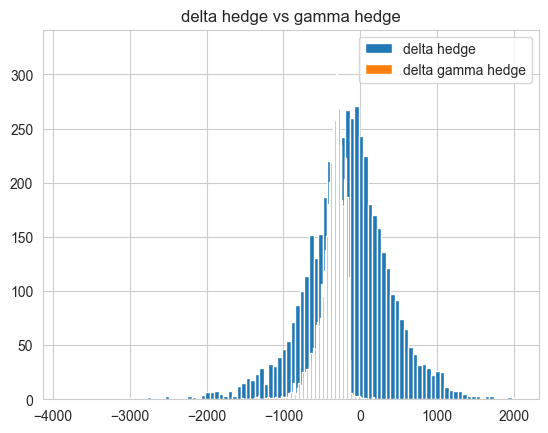

In [74]:
plt.hist(delta_hedge_base.M[:,-1],bins=100,label='delta hedge')
plt.hist(delta_gamma_hedge_base.M[:,-1],bins=100,label='delta gamma hedge')
plt.title('delta hedge vs gamma hedge')
plt.legend()
plt.show()

# Q1

In [75]:
end_pnl_delta=[]
end_pnl_delta_gamma=[]
for i in np.linspace(0.05,2.0,4):
    obj=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=i,sigma=0.25,sigma_real=0.25,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta')
    obj2=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=i,sigma=0.25,sigma_real=0.25,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta-gamma',hedging_option_maturity=0.3)
    end_pnl_delta.append(obj.M[:,-1])
    end_pnl_delta_gamma.append(obj2.M[:,-1])

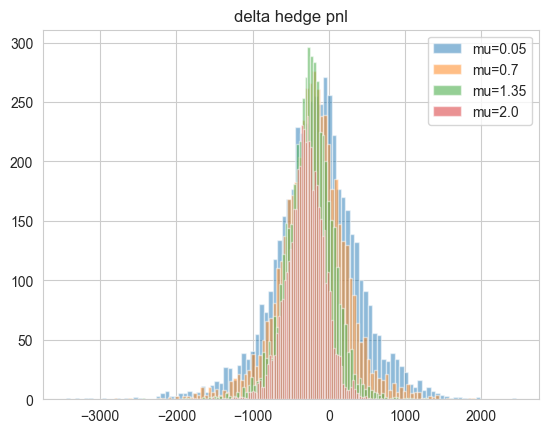

In [76]:
for idx,data in enumerate(end_pnl_delta):
    plt.hist(data,bins=100,label='mu={}'.format(np.round(np.linspace(0.05,2.0,4)[idx],2)),alpha=0.5)
plt.title('delta hedge pnl')
plt.legend()
plt.show()

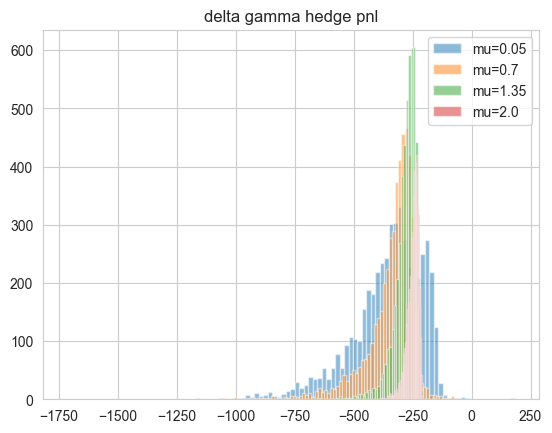

In [77]:
for idx,data in enumerate(end_pnl_delta_gamma):
    plt.hist(data,bins=100,label='mu={}'.format(np.round(np.linspace(0.05,2.0,4)[idx],2)),alpha=0.5)
plt.title('delta gamma hedge pnl')
plt.legend()
plt.show()

# Q2    

In [78]:
# plot subplots of delta hedge and delta gamma hedge for their stock path, alpha position, m position

In [79]:
def plot_delta_hedge(delta_hedge_base:ATM_Call_Option_Dynamic_Hedging_Following_prof,trial:int):
    # fig,ax=plt.subplots(4,1,figsize=(10,20))
    fig,ax=plt.subplots(3,1,figsize=(10,20))
    ax[0].plot(delta_hedge_base.t,delta_hedge_base.S[trial,:],label='stock price')
    ax[0].set_title('stock price')
    ax[0].legend()
    ax[1].plot(delta_hedge_base.t,delta_hedge_base.alpha[trial,:],label='alpha position')
    ax[1].set_title('alpha position')
    ax[1].legend()
    ax[2].plot(delta_hedge_base.t,delta_hedge_base.M[trial,:],label='M position')
    ax[2].set_title('M position')
    ax[2].legend()
    # ax[3].hist(delta_hedge_base.M[:,-1],bins=100,label='delta hedge pnl')
    # ax[3].set_title('delta hedge pnl')
    # ax[3].legend()
    plt.show()
    

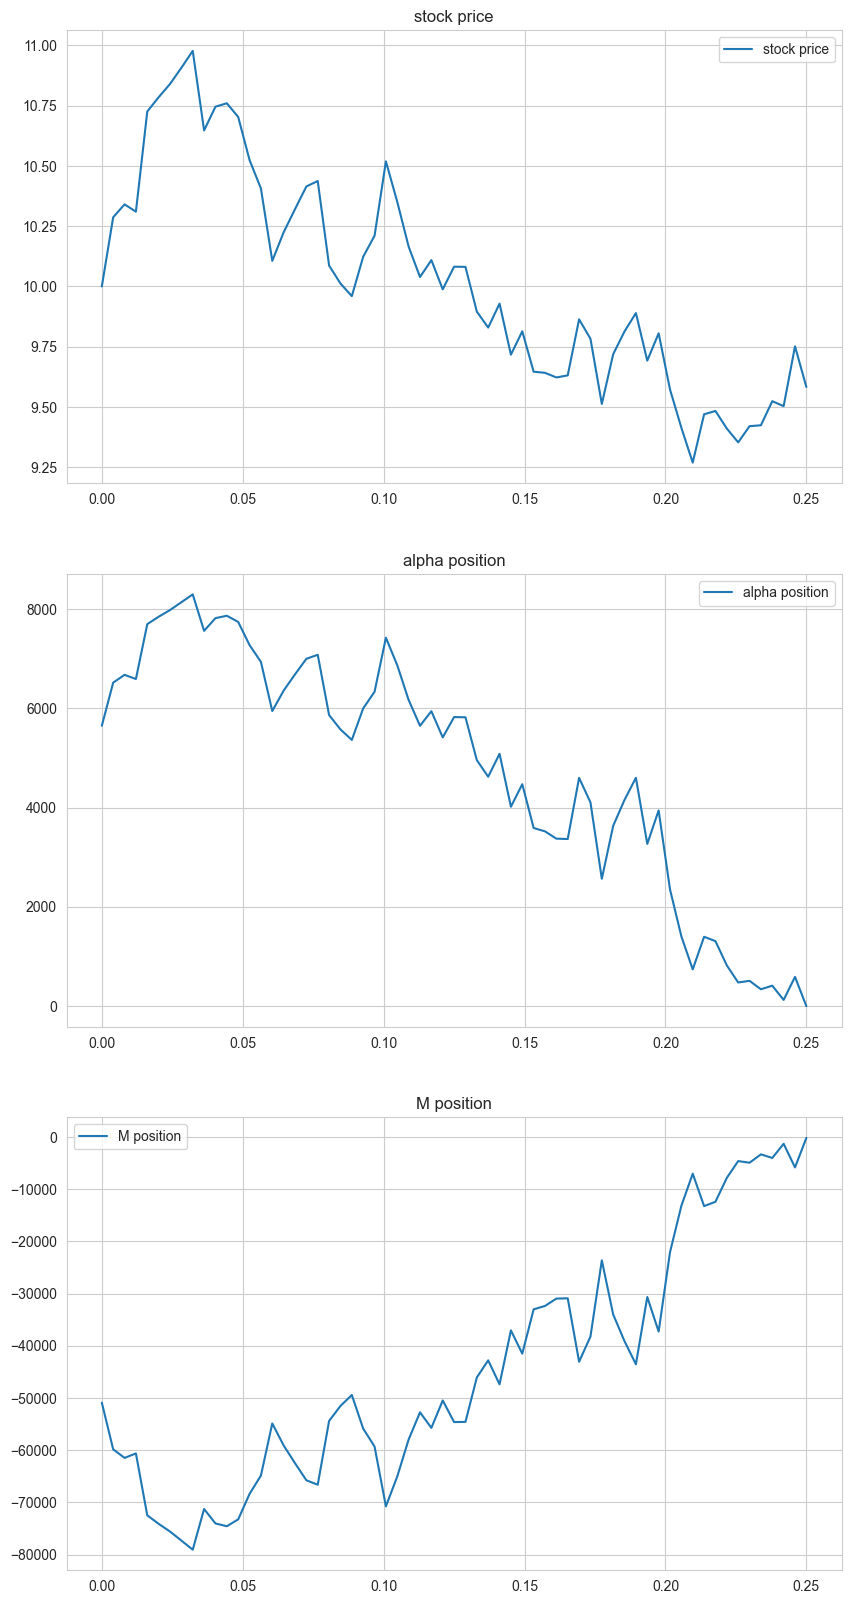

In [80]:
plot_delta_hedge(delta_hedge_base,trial=0)

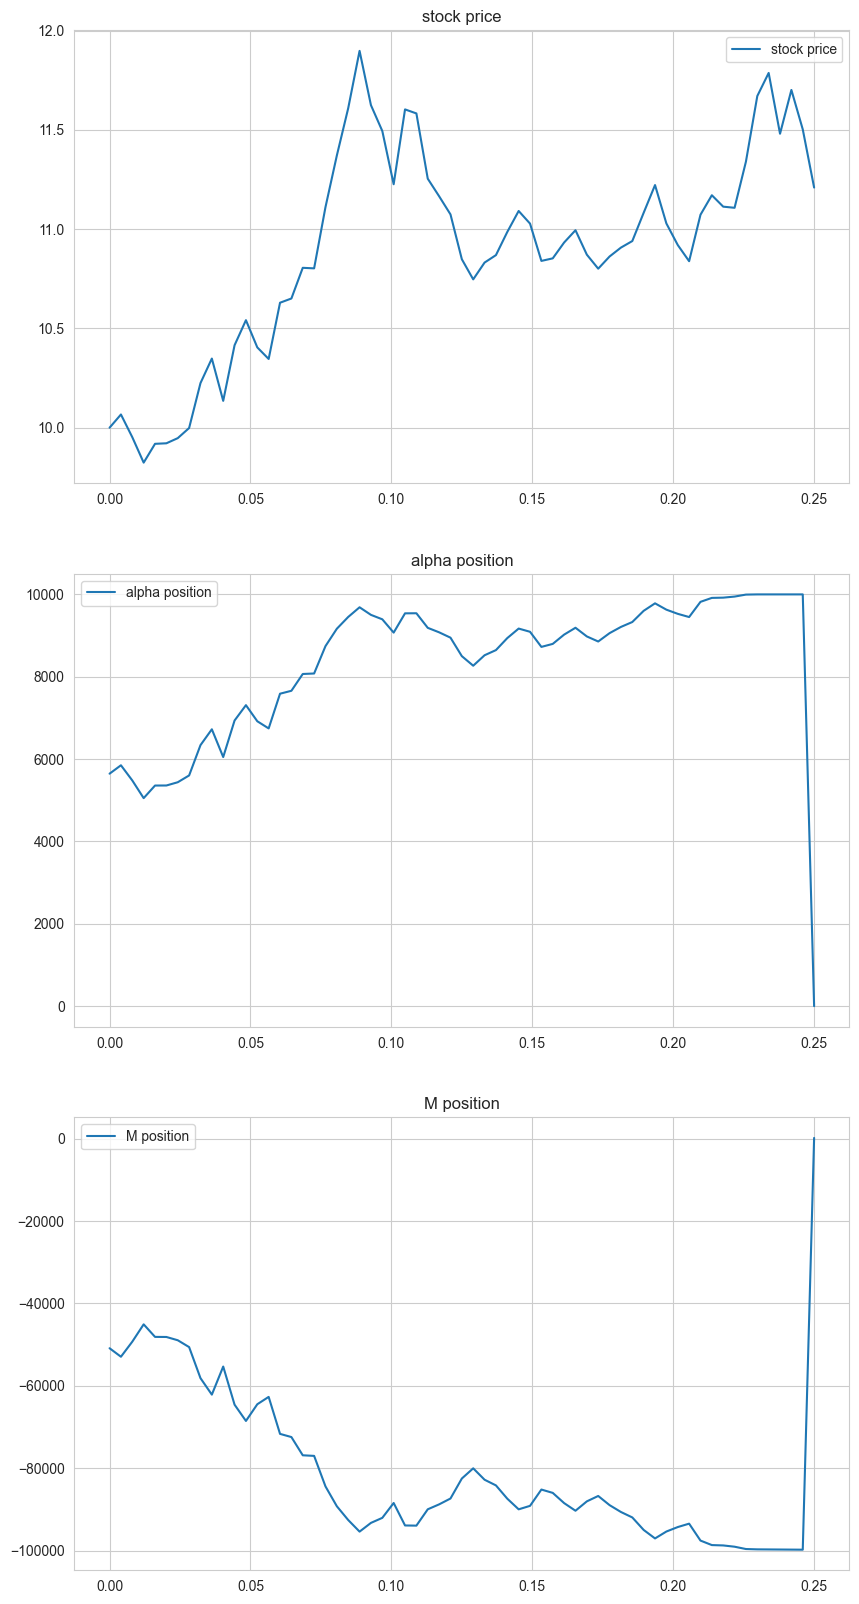

In [81]:
plot_delta_hedge(delta_hedge_base,trial=1)

In [82]:

def plot_delta_gamma_hedge(delta_gamma_hedge_base:ATM_Call_Option_Dynamic_Hedging_Following_prof,trial:int):
    # fig,ax=plt.subplots(5,1,figsize=(10,20))
    fig,ax=plt.subplots(4,1,figsize=(10,20))
    ax[0].plot(delta_gamma_hedge_base.t,delta_gamma_hedge_base.S[trial,:],label='stock price')
    ax[0].set_title('stock price')
    ax[0].legend()
    ax[1].plot(delta_gamma_hedge_base.t,delta_gamma_hedge_base.alpha[trial,:],label='alpha position')
    ax[1].set_title('alpha position')
    ax[1].legend()
    ax[2].plot(delta_gamma_hedge_base.t,delta_gamma_hedge_base.M[trial,:],label='M position')
    ax[2].set_title('M position')
    ax[2].legend()
    ax[3].plot(delta_gamma_hedge_base.t,delta_gamma_hedge_base.gamma[trial,:],label='gamma position')
    ax[3].set_title('gamma position')
    ax[3].legend()
    # ax[4].hist(delta_gamma_hedge_base.M[:,-1],bins=100,label='delta gamma hedge pnl')
    # ax[4].set_title('delta gamma hedge pnl')
    # ax[4].legend()
    plt.show()

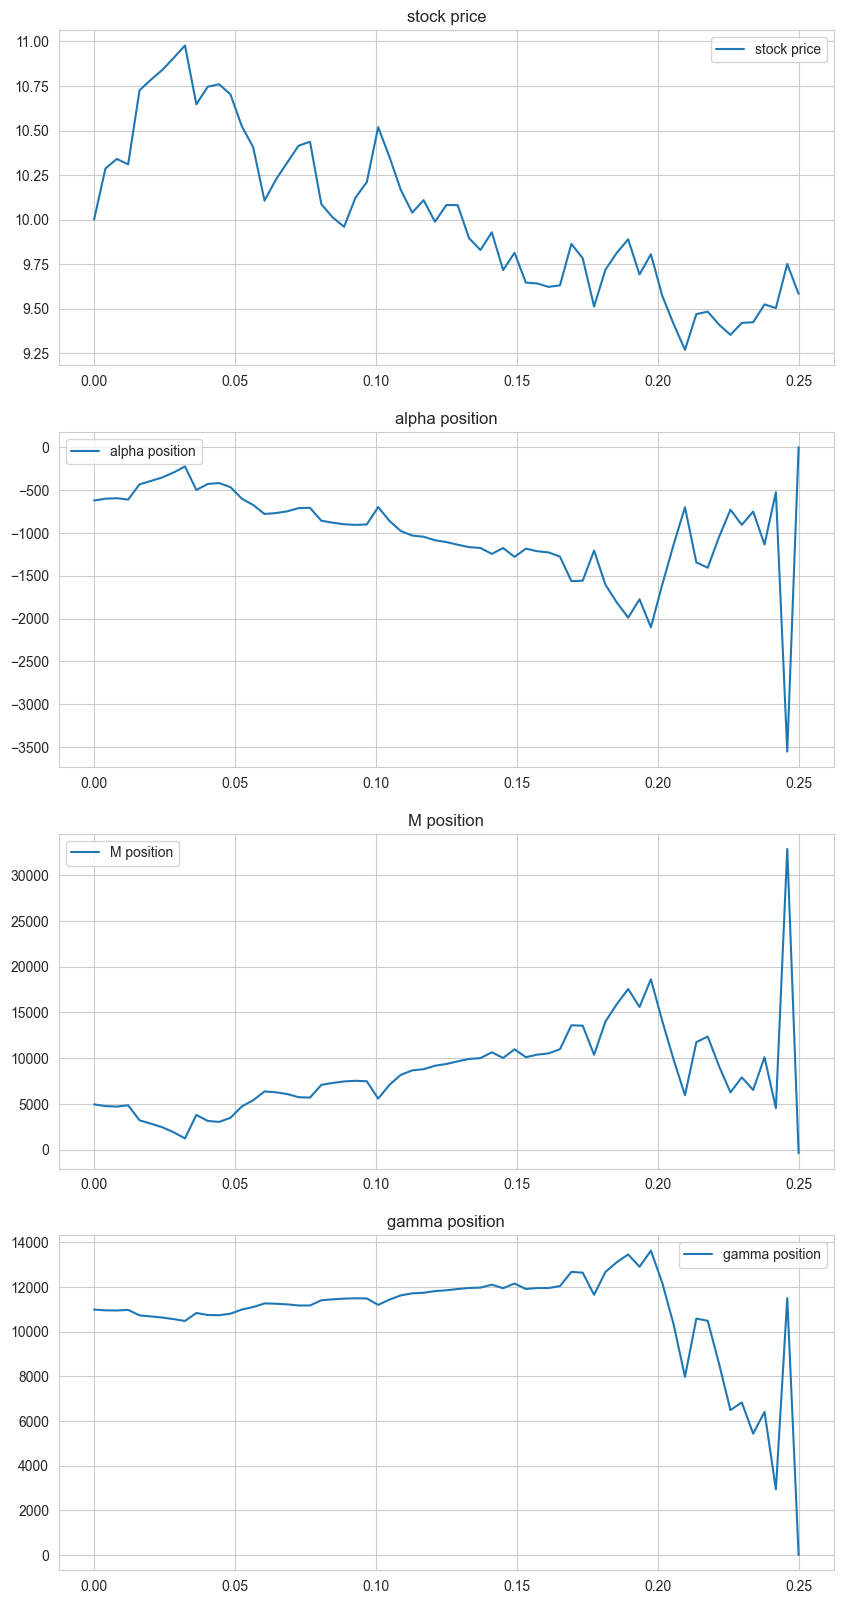

In [83]:
plot_delta_gamma_hedge(delta_gamma_hedge_base,trial=0)

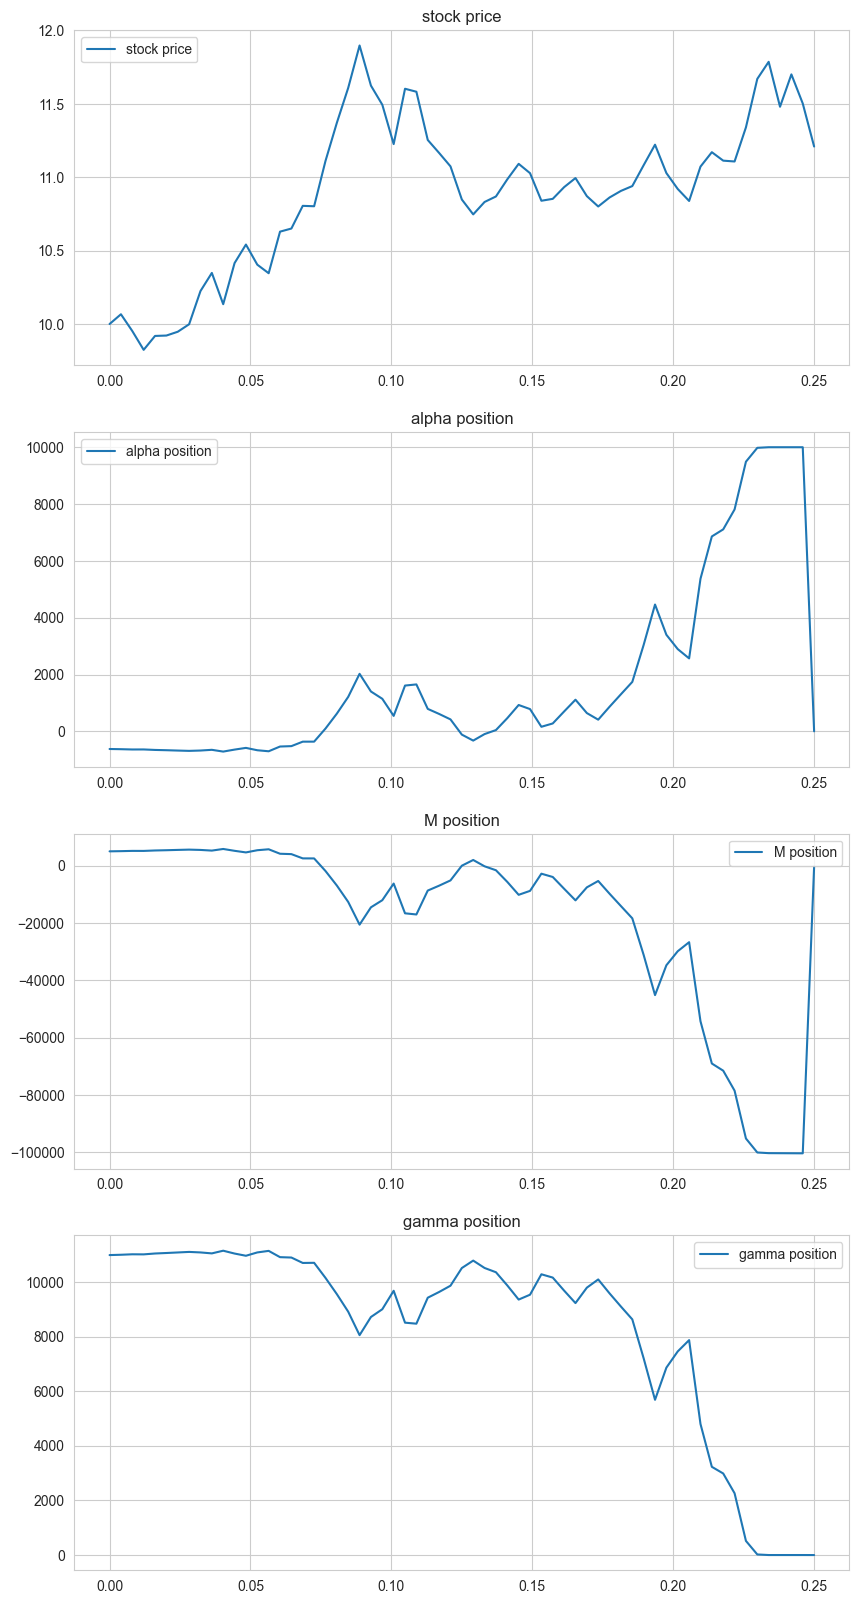

In [84]:
plot_delta_gamma_hedge(delta_gamma_hedge_base,trial=1)

In [85]:
pnl_delta_vol=[]
pnl_delta_gamma_vol=[]
for i in np.linspace(0.2, 0.3,5):
    obj=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=0.1,sigma=0.25,sigma_real=i,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta')
    obj2=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=0.1,sigma=0.25,sigma_real=i,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta-gamma',hedging_option_maturity=0.3)
    pnl_delta_vol.append(obj.M[:,-1])
    pnl_delta_gamma_vol.append(obj2.M[:,-1])

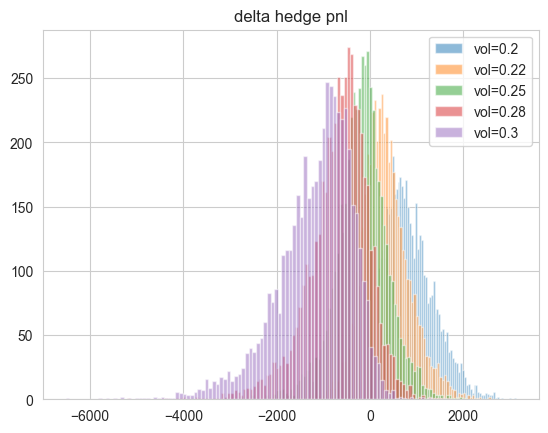

In [86]:
for idx,data in enumerate(pnl_delta_vol):
    plt.hist(data,bins=100,label='vol={}'.format(np.round(np.linspace(0.2, 0.3,5)[idx],2)),alpha=0.5)
plt.title('delta hedge pnl')
plt.legend()
plt.show()

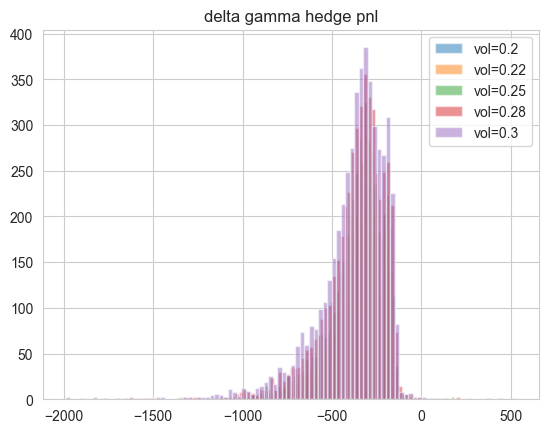

In [87]:
for idx,data in enumerate(pnl_delta_gamma_vol):
    plt.hist(data,bins=100,label='vol={}'.format(np.round(np.linspace(0.2, 0.3,5)[idx],2)),alpha=0.5)
plt.title('delta gamma hedge pnl')
plt.legend()
plt.show()